In [1]:
import numpy as np
import tensorflow as tf
from utility_functions import *
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [2]:
X,Y = generate_data(
    xlim = [-1,1],
    ylim = [-1,1], 
    n_point_per_axis = [20,10], 
    lenth_per_slab = 0.4, 
    width_per_slab = 0.2, 
    gap_to_edge_1 = [0.1,0.15],
    gap_to_edge_2 = [0.1, 0.5],
    n_slab1 = 3, 
    n_slab2 = 2,
)
Y = tf.cast(Y,'int32')

In [3]:
import scipy
def entropy(x, use_sm = 1):
    if use_sm:
        x = scipy.special.softmax(x, axis = -1)
    e = np.zeros(len(x))
    for i,xi in enumerate(x):
        for j, xij in enumerate(xi):
            e[i] -=xij*np.log2(xij)
    return e

In [4]:
newcolors = np.array([[0/256, 0/256, 0/256, 1],
                   [256/256, 256/256, 256/256, 1]])
newcmp = ListedColormap(newcolors)

blockcolors = np.array([[256/256, 0/256, 0/256, 1],
                   [0/256, 0/256, 256/256, 1]])
blockcmp = ListedColormap(blockcolors)

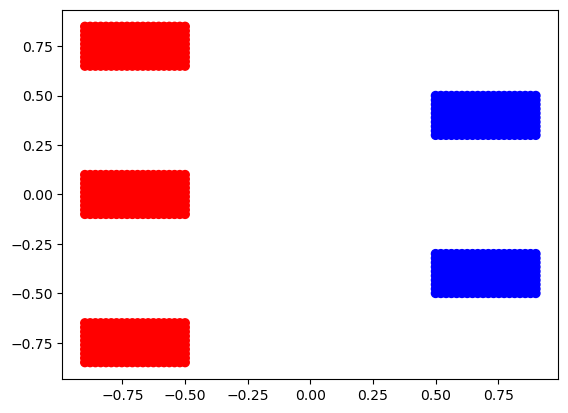

In [5]:
plt.scatter(X[:,0],X[:,1], c=Y, cmap = blockcmp)

In [6]:
class BMF_loss(tf.keras.losses.Loss):
    def __init__(self, coeff, beta_func = 0):
        super().__init__()
        self.coeff = coeff
        self.beta_func = beta_func
    def call(self, y_true, y_pred):
        # separate the input and output
        inp = y_true[:,1:]
        y_true = y_true[:,0]
        
        # add a small number to avoid alpha = 0
        alphas = tf.math.exp(y_pred)+1.0e-8
        betas = tf.ones_like(y_pred) * self.beta_func(inp)
        a_ans = tf.gather(alphas,axis=-1, indices = tf.cast(y_true,'int32'), batch_dims = 1)
        a_zero = tf.math.reduce_sum(alphas,-1)
        beta_zero = tf.math.reduce_sum(betas,-1)
        
        l1_loss = tf.math.digamma(a_ans) - tf.math.digamma(a_zero)
        loss1 = tf.math.lgamma(a_zero) - tf.math.reduce_sum(tf.math.lgamma(alphas), -1)
        loss1 += -tf.math.lgamma(beta_zero) + tf.math.reduce_sum(tf.math.lgamma(betas), -1)
        loss2 = tf.math.reduce_sum((alphas - betas)*(tf.math.digamma(alphas) - tf.math.digamma(tf.expand_dims(a_zero,-1))),-1)

        kl_loss = loss1 + loss2
        loss = tf.math.reduce_mean(self.coeff*kl_loss - l1_loss)
        return loss

In [7]:
coeff = 0.3
activation = 'relu'



def prior_exp(beta_func,coeff = coeff):
    model = tf.keras.Sequential ()
    model.add(tf.keras.layers.Dense(50, activation=activation, use_bias=True, input_shape=(2,)))
    model.add(tf.keras.layers.Dense(50, activation=activation ,use_bias=True,))
    model.add(tf.keras.layers.Dense(2))
    model.compile(optimizer = tf.keras.optimizers.Adam(), loss = BMF_loss(coeff = coeff, beta_func = beta_func))

    model.fit(X,np.append(tf.expand_dims(Y, axis = -1),X[:,:],axis = 1),epochs = 200, verbose = 0)
    result,xx,yy = draw_prediction(model, xlim = [-1,1], ylim = [-1,1], num = [200,200])
    prediction = np.argmax(result, axis = -1)
   
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.scatter(xx,yy, c=prediction, label='decision boundary',cmap= newcmp)
    ax1.scatter(X[:,0],X[:,1], c=Y, label='data',cmap = blockcmp)
    plt.show()
    return result

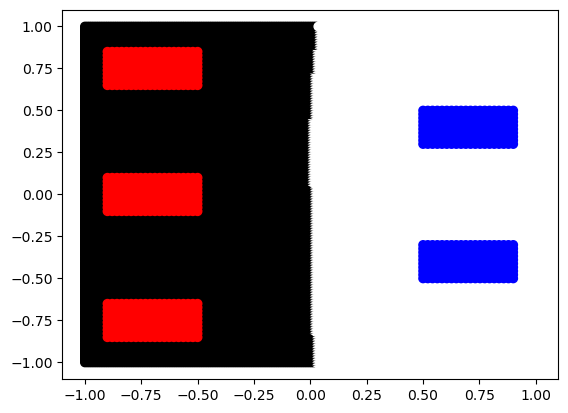

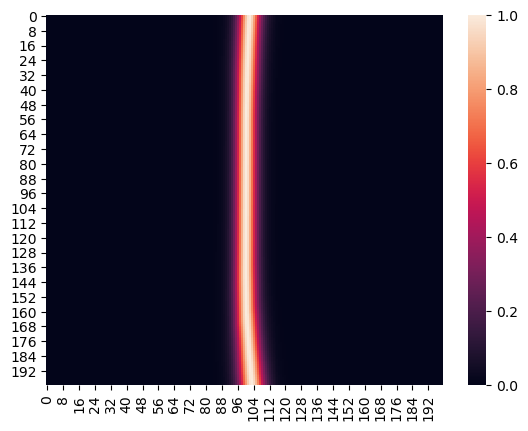

In [8]:
def func1em8(x):
    return [1e-8,1e-8]
result = prior_exp(func1em8)
a = entropy(result)
ax = sns.heatmap(tf.reshape(a,[200,200]))
plt.show()

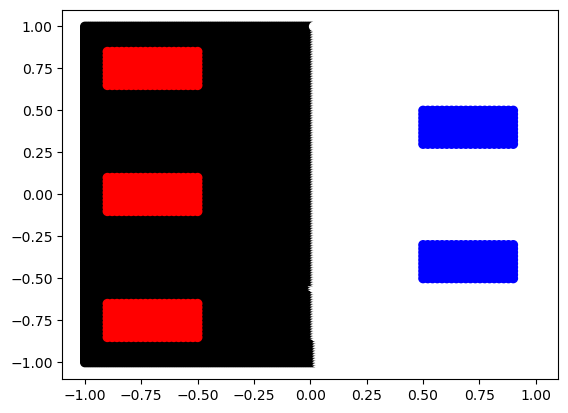

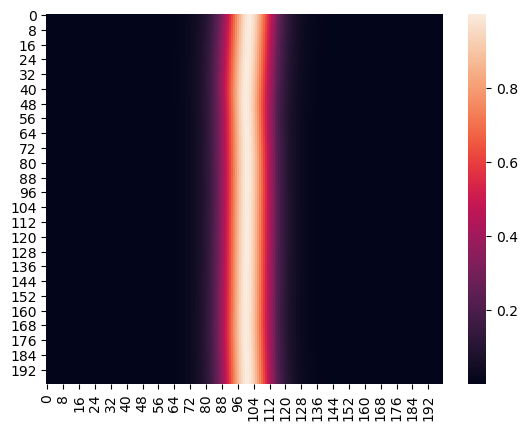

In [9]:
def func1em4(x):
    return [1e-4,1e-4]
result = prior_exp(func1em4)
a = entropy(result)
ax = sns.heatmap(tf.reshape(a,[200,200]))
plt.show()

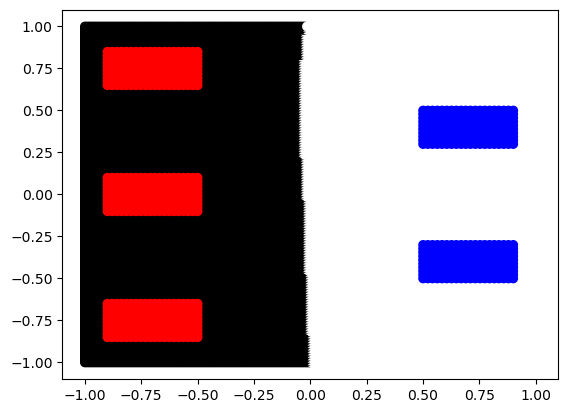

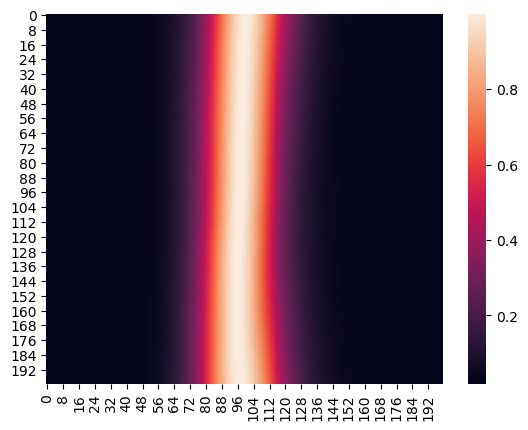

In [10]:
def func1em2(x):
    return [1e-2,1e-2]
result = prior_exp(func1em2)
a = entropy(result)
ax = sns.heatmap(tf.reshape(a,[200,200]))
plt.show()

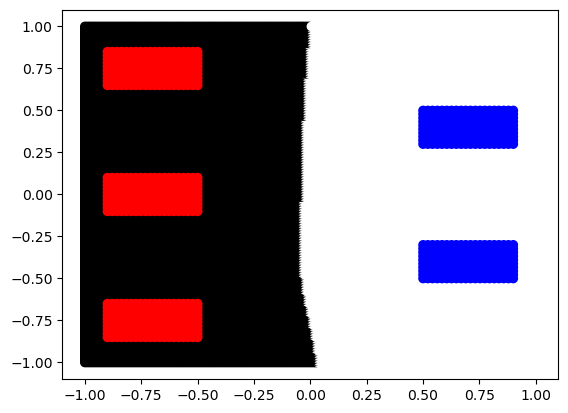

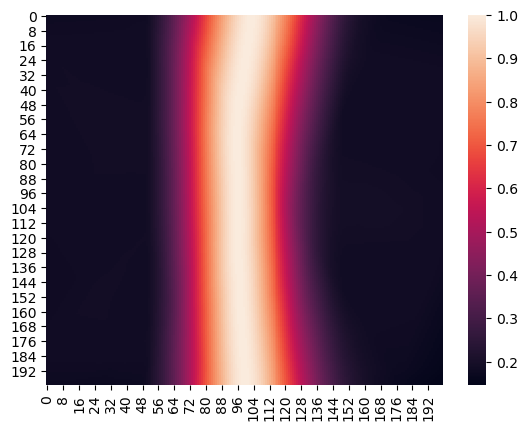

In [11]:
def func1em1(x):
    return [1e-1,1e-1]
result = prior_exp(func1em1)
a = entropy(result)
ax = sns.heatmap(tf.reshape(a,[200,200]))
plt.show()